In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

In [2]:
img_shape = 128
input_shape = (img_shape, img_shape, 3)
EPOCHS = 20
BATCH_SIZE = 32

In [3]:
def process_path(file_path):
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label_arr = None
    if label == 'fake':
        label_arr = 0
    else:
        label_arr = 1
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [img_shape, img_shape])
    img = tf.image.convert_image_dtype(img, tf.float32)
    return (img, label_arr)

def scale(image, label):
    return (image / 255, label)

train_ds = tf.data.Dataset.list_files('1framedfd/dataset/train/*/*')
test_ds = tf.data.Dataset.list_files('1framedfd/dataset/test/*/*')
val_ds = tf.data.Dataset.list_files('1framedfd/dataset/valid/*/*')

train_size = len(train_ds)
val_size = len(val_ds)

train_ds = train_ds.shuffle(train_size).map(process_path, num_parallel_calls = tf.data.AUTOTUNE).map(scale, num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).repeat(EPOCHS).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(val_size).map(process_path, num_parallel_calls = tf.data.AUTOTUNE).map(scale, num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(val_size).map(process_path, num_parallel_calls = tf.data.AUTOTUNE).map(scale, num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [4]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, LeakyReLU, Concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer, Rescaling
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [5]:
inception_resnet = InceptionResNetV2(include_top = False, weights = 'imagenet', input_shape = input_shape)
inception_resnet.trainable = True
model = Sequential()
model.add(inception_resnet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [5]:
model = load_model('models/dfd_model_nvidia_dataset')

In [6]:
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-3), metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                24592     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 54,361,345
Trainable params: 54,300,801
Non-trainable params: 60,544
_________________________________________________________________


In [7]:
checkpoint_callback = ModelCheckpoint(
    filepath = 'checkpoints/best_dfd_both.hdf5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    mode = 'min')

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_lr = 0.0001)

STEPS = train_size // BATCH_SIZE
callbacks = [checkpoint_callback, reduce_lr]
history = model.fit(train_ds, batch_size = BATCH_SIZE, steps_per_epoch = STEPS, epochs = EPOCHS, callbacks = callbacks, validation_data = val_ds, verbose = 1)

Epoch 1/10
2390/2390 [==============================] - 528s 214ms/step - loss: 0.4719 - accuracy: 0.8271 - val_loss: 0.4119 - val_accuracy: 0.8297

Epoch 00001: val_loss improved from inf to 0.41192, saving model to checkpoints\best_dfd_both.hdf5
Epoch 2/10
2390/2390 [==============================] - 514s 215ms/step - loss: 0.4007 - accuracy: 0.8324 - val_loss: 0.3769 - val_accuracy: 0.8431

Epoch 00002: val_loss improved from 0.41192 to 0.37693, saving model to checkpoints\best_dfd_both.hdf5
Epoch 3/10
2390/2390 [==============================] - 538s 225ms/step - loss: 0.3553 - accuracy: 0.8528 - val_loss: 0.3458 - val_accuracy: 0.8554

Epoch 00003: val_loss improved from 0.37693 to 0.34576, saving model to checkpoints\best_dfd_both.hdf5
Epoch 4/10
2390/2390 [==============================] - 495s 207ms/step - loss: 0.3631 - accuracy: 0.8511 - val_loss: 0.3369 - val_accuracy: 0.8619

Epoch 00004: val_loss improved from 0.34576 to 0.33686, saving model to checkpoints\best_dfd_both.h

INFO:tensorflow:Assets written to: models/dfd_model_both\assets


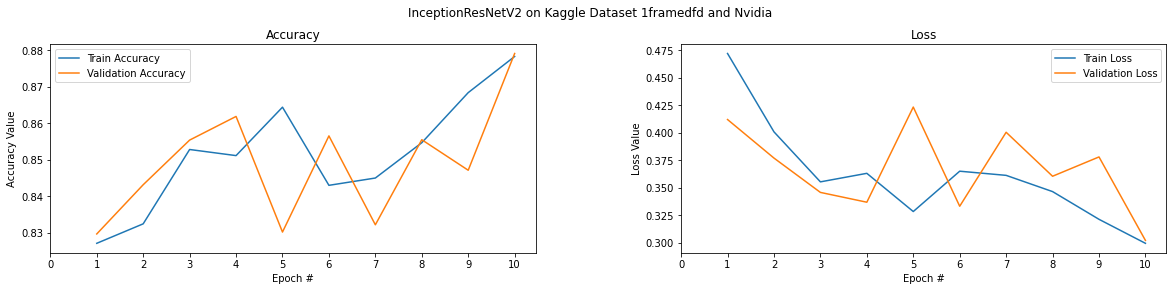

In [9]:
model.save('models/dfd_model_both')

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 4))
t = f.suptitle('InceptionResNetV2 on Kaggle Dataset 1framedfd and Nvidia', fontsize = 12)
f.subplots_adjust(top = 0.85, wspace = 0.3)

epoch_list = list(range(1, EPOCHS + 1))
ax1.plot(epoch_list, history.history['accuracy'], label = 'Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS + 1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label = 'Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label = 'Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS + 1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc = "best")

In [8]:
results = model.evaluate(test_ds)
print(model.metrics_names)
print(results)

299/299 [==============================] - 22s 72ms/step - loss: 0.2915 - accuracy: 0.8811
['loss', 'accuracy']
[0.2915068566799164, 0.8811042308807373]


True positive =  124
False positive =  4
False negative =  79
True negative =  49
Precision =  0.96875
Recall =  0.6108374384236454
Fscore =  0.7492447129909365




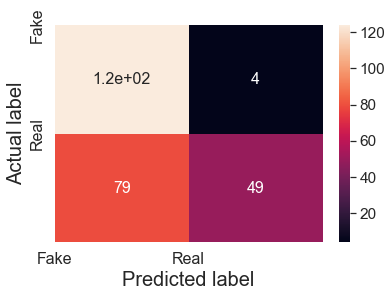

In [10]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = (2 * precision * recall) / (precision + recall)
    print('True positive = ', tp)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True negative = ', tn)
    print('Precision = ', precision)
    print('Recall = ', recall)
    print('Fscore = ', fscore)
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [img_shape, img_shape])
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def scale(image):
    return (image / 255)
    
model = load_model('models/dfd_model_both')
data_dir = '1framedfd/dataset/test'
real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.jpg')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.jpg')]
real_data = random.sample(real_data, 128)
fake_data = random.sample(fake_data, 128)
X = []
Y = []
for img in real_data:
    res = scale(process_path(data_dir+'/real/'+img))
    X.append(res)
    Y.append(1)
for img in fake_data:
    res = scale(process_path(data_dir+'/fake/'+img))
    X.append(res)
    Y.append(0)
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)
Y_true = Y
Y_pred = model.predict(X)

print_confusion_matrix(Y_true, np.round(Y_pred))